In [1]:
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math
import h5py
import os.path


import torch.nn.functional as F
from timeit import default_timer
from catheter import *
from utilities3 import *
from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

# Length based data

In [5]:
PATH =  "/home/wumming/Documents/GNN-PDE/Geo-FNO-catheter/data/test/"
INPUT_X = PATH+"x_1d_structured_mesh.npy"
INPUT_Y = PATH+"y_1d_structured_mesh.npy"
INPUT_para = PATH+"data_info.npy"
OUTPUT = PATH+"density_1d_data.npy"
n_data = 3000
inputX_raw = np.load(INPUT_X)[:,0:n_data]
inputY_raw = np.load(INPUT_Y)[:,0:n_data]
inputPara_raw = np.load(INPUT_para)[:,0:n_data]
output_raw = np.load(OUTPUT)[:,0:n_data]

N_s, L_x = 2001, 500


# PATH = "/groups/esm/dzhuang/Catheter/allparam/length/"
INPUT_INFO = PATH+"data_info.npy"
dataInfo = np.load(INPUT_INFO)



################################################################
# load data and data normalization
################################################################

inputX = inputX_raw[:, 0::3]
inputY = inputY_raw[:, 0::3]
inputPara = inputPara_raw[:, 0::3]
output = (output_raw[:, 0::3] + output_raw[:, 1::3] + output_raw[:, 2::3])/ 3.0

n_data = output.shape[1]
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
output_loss = -np.dot(xx_mask, output) * L_x/N_s




In [6]:
# linear regression model
A = np.ones((n_data, 5))
# sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]

A[:, 0] = inputPara[2, :]
A[:, 1] = inputPara[4, :]
A[:, 2] = inputPara[5, :]
A[:, 3] = inputPara[6, :]

coeff, residuals, _, _ = np.linalg.lstsq(A, output_loss)

print(" linear regression :coeff L_p, x2, x3, h, 1 = ", coeff)
np.mean(  np.abs(np.dot(A, coeff) - output_loss) / output_loss  )


 linear regression :coeff L_p, x2, x3, h, 1 =  [  4466.24758775  -8632.45529488  -2051.85571083 -39091.50533066
 887083.98641528]


/tmp/ipykernel_5634/3313245278.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff, residuals, _, _ = np.linalg.lstsq(A, output_loss)


0.11674291129077032

In [7]:
output_loss.shape

(100,)

In [8]:
# linear regression model
A = np.ones((n_data, 5))
# sample, uf, L_p, x1, x2, x3, h = inputPara[:, i]

A[:, 0] = inputPara[2, :]
A[:, 1] = inputPara[4, :] - inputPara[2, :]/2.0
A[:, 2] = inputPara[5, :] - inputPara[2, :]/2.0
A[:, 3] = inputPara[6, :]

coeff, residuals, _, _ = np.linalg.lstsq(A, output_loss)

print(" linear regression :coeff L_p, x2, x3, h, 1 = ", coeff)
np.mean(  np.abs(np.dot(A, coeff) - output_loss) / output_loss  )


 linear regression :coeff L_p, x2, x3, h, 1 =  [-8.75907915e+02 -8.63245529e+03 -2.05185571e+03 -3.90915053e+04
  8.87083986e+05]


/tmp/ipykernel_5634/1672342259.py:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coeff, residuals, _, _ = np.linalg.lstsq(A, output_loss)


0.11674291129077041

In [13]:
# fno model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = torch.load("catheter_plain_length_model_1d1000", map_location=device)
model2 = torch.load("FNO1d_updated_m12w128e400_noise_mask", map_location=device)

print(count_params(model))
inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
input = torch.stack([inputX, inputY], dim=-1)
output = torch.tensor(output, dtype=torch.float).permute(1,0)

ntrain = n_data
x_train = input.to(device).reshape(ntrain, N_s, 2)
pred = np.zeros((n_data, N_s))
pred2 = np.zeros((n_data, N_s))
for i in range(n_data):
    # pred[i, :] = torch.clip(model(x_train[i:i+1,:,:]).squeeze(), min=0.0).detach().cpu().numpy()
    # pred[i, :] = torch.clip(model(x_train[i:i+1,:,:].to(device)), min=0.0).detach().cpu().numpy().flatten()
    # pred[i, :] = torch.abs(model(x_train[i:i+1,:,:].to(device))).detach().cpu().numpy().flatten()
    pred[i, :] = torch.exp(model(x_train[i:i+1,:,:].to(device))).detach().cpu().numpy().flatten()
    pred2[i, :] = torch.exp(model2(x_train[i:i+1,:,:].to(device))).mean(-1).detach().cpu().numpy().flatten()
    
    
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
fno_loss = -np.dot(pred, xx_mask) * L_x/N_s

print("FNO mean loss error: ",  np.mean(  np.abs(fno_loss - output_loss) / output_loss  ) )
print("FNO max loss error: ",  np.max(  np.abs(fno_loss - output_loss) / output_loss  ) )

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
fno_loss = -np.dot(pred2, xx_mask) * L_x/N_s

print("FNO mean loss error: ",  np.mean(  np.abs(fno_loss - output_loss) / output_loss  ) )
print("FNO max loss error: ",  np.max(  np.abs(fno_loss - output_loss) / output_loss  ) )

1336001


/tmp/ipykernel_5634/514794601.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputX = torch.tensor(inputX, dtype=torch.float).permute(1,0)
/tmp/ipykernel_5634/514794601.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputY = torch.tensor(inputY, dtype=torch.float).permute(1,0)
/tmp/ipykernel_5634/514794601.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(output, dtype=torch.float).permute(1,0)


FNO mean loss error:  0.025992152611350846
FNO max loss error:  0.40818484730909643
FNO mean loss error:  0.023014244846446975
FNO max loss error:  0.14730528690634964


In [7]:
fno_loss_min_ind = np.argmin(fno_loss)
print("fno min = ", fno_loss[fno_loss_min_ind], " at ", fno_loss_min_ind)
print("sample, uf, L_p, x1, x2, x3, h = ", inputPara[:, fno_loss_min_ind])
print("truth eval = ", output_loss[fno_loss_min_ind])
print("error = ", np.abs((fno_loss[fno_loss_min_ind] - output_loss[fno_loss_min_ind])/output_loss[fno_loss_min_ind]))

loss_min_ind = np.argmin(output_loss)
print("truth min = ", output_loss[loss_min_ind], " at ", loss_min_ind)
print("sample, uf, L_p, x1, x2, x3, h = ", inputPara[:, loss_min_ind])
print("fno eval = ", fno_loss[loss_min_ind])
print("error = ", np.abs((fno_loss[loss_min_ind] - output_loss[loss_min_ind])/output_loss[loss_min_ind]))


fno min =  262338.70631641813  at  784
sample, uf, L_p, x1, x2, x3, h =  [785.           5.03008     62.87507539 -31.43753769  -8.69985683
 -15.85508335  28.01017283]
truth eval =  262913.03325813607
error =  0.0021844749748638295
truth min =  262913.03325813607  at  784
sample, uf, L_p, x1, x2, x3, h =  [785.           5.03008     62.87507539 -31.43753769  -8.69985683
 -15.85508335  28.01017283]
fno eval =  262338.70631641813
error =  0.0021844749748638295


262338.70631641813


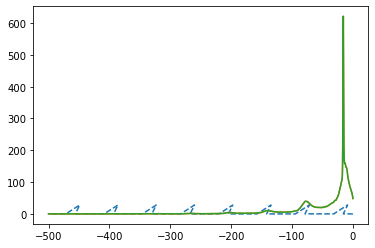

In [8]:
# L_p, x2, x3, h
# fix L_p, h
sample, uf, L_p, x1, x2, x3, h = inputPara[:, fno_loss_min_ind]
L_p, x2, x3, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(x2, dtype=torch.float), torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)
X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)


X_Y_numpy = X_Y.cpu().numpy()
plt.plot(X_Y_numpy[0, :, 0], X_Y_numpy[0, :, 1], "--")

X_Y = x_train[fno_loss_min_ind:fno_loss_min_ind+1,:,:]
out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = -np.dot(out, xx_mask)* L_x/N_s
plt.plot(xx_mask, out)
plt.plot(xx_mask, out)
print(loss)

In [9]:
# L_p, x2, x3, h
# fix L_p, h
L_p, h = 62.2564697265625,  29.99827766418457
L_p, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(h, dtype=torch.float)

# 60.89578107 -30.44789053  -3.74659224 -15.23394195  28.72308896
nx2, nx3 = 60*2+1, np.int64((L_p/2-15)*2+1)
x2_range = np.linspace(-L_p, 0.0, nx2)
# x3_range = np.linspace(-L_p/2+15, 0.0, nx3)
# x2_range = np.linspace(-40, 0.0, nx2)
x3_range = np.linspace(-20, 0.0, nx3)
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(x2_range), len(x3_range)))
for i in range(len(x2_range)):
    for j in range(len(x3_range)):
        x2, x3 = torch.tensor(x2_range[i], dtype=torch.float), torch.tensor(x3_range[j], dtype=torch.float)
        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        
        out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()
                
        loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        

In [14]:
# L_p, x2, x3, h
# fix L_p, h
L_p, h = 62.2564697265625,  29.99827766418457
L_p, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(h, dtype=torch.float)

# 60.89578107 -30.44789053  -3.74659224 -15.23394195  28.72308896
nx2, nx3 = 60*2+1, np.int64((L_p/2-15)*2+1)
x2_range = np.linspace(-L_p, 0.0, nx2)
# x3_range = np.linspace(-L_p/2+15, 0.0, nx3)
# x2_range = np.linspace(-40, 0.0, nx2)
x3_range = np.linspace(-20, 0.0, nx3)
xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(x2_range), len(x3_range)))
for i in range(len(x2_range)):
    for j in range(len(x3_range)):
        x2, x3 = torch.tensor(x2_range[i], dtype=torch.float), torch.tensor(x3_range[j], dtype=torch.float)
        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)
        
        out = torch.exp(model2(X_Y)).mean(-1).squeeze().detach().cpu().numpy()
                
        loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s

(33, 121) (33, 121) (121, 33)


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


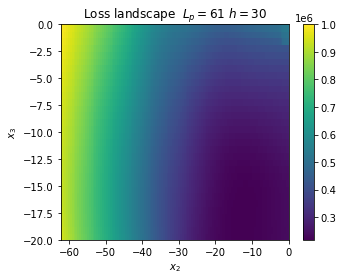

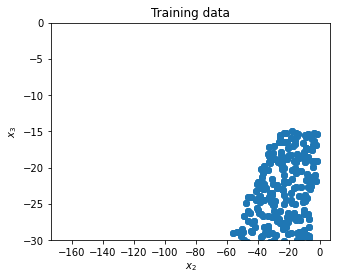

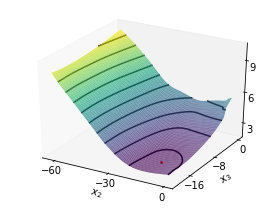

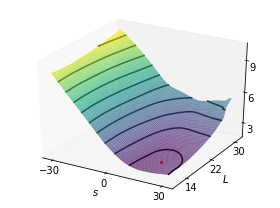

In [13]:
X, Y = np.meshgrid(x2_range ,x3_range)
plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, loss.transpose())
# plt.colorbar(format='%.0e')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Loss landscape "+r" $L_p=61 ~ h=30$")
plt.tight_layout()
plt.savefig("landscape-x2-x3.pdf")

plt.figure(figsize=(5,4))
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Training data")
plt.ylim([-30, 0])


fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
print(X.shape, Y.shape, loss.shape)
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")
ax.scatter([-11.565677642822266], [-15.864848136901855], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, linewidth=0)
ax.grid(False)

ax.view_init(30, -60)
ax.set_xticks([0, -30, -60])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$x_2$", labelpad=-5)
ax.set_yticks([0, -8, -16])
ax.tick_params(axis='y', which='major', pad=-4)

ax.set_ylabel(r"$x_3$", labelpad=-5)
ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()




# update to L, s coordinate

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
x1 = L_p.item()/2.0
X += x1
Y += x1
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")
ax.scatter([-11.565677642822266 + x1], [-15.864848136901855 + x1], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, linewidth=0)
ax.grid(False)

ax.view_init(30, -60)
ax.set_xticks([30, 0, -30])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$s$", labelpad=-5)
ax.set_yticks([30, 22, 14])
ax.tick_params(axis='y', which='major', pad=-4)

ax.set_ylabel(r"$L$", labelpad=-5)
ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()
fig.savefig("landscape-1.pdf")

(33, 121) (33, 121) (121, 33)


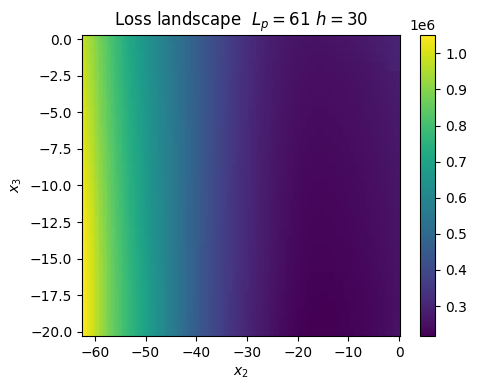

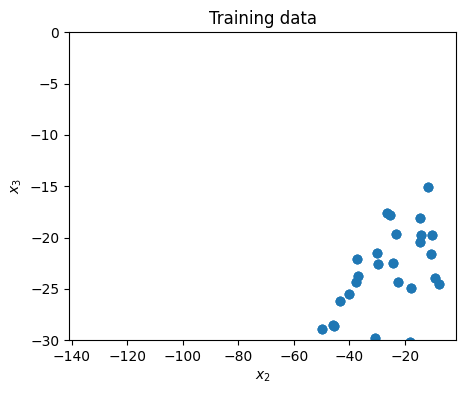

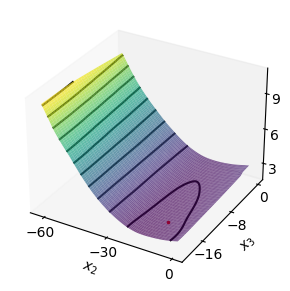

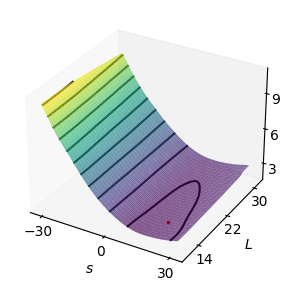

In [15]:
X, Y = np.meshgrid(x2_range ,x3_range)
plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, loss.transpose())
# plt.colorbar(format='%.0e')
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Loss landscape "+r" $L_p=61 ~ h=30$")
plt.tight_layout()
plt.savefig("landscape-x2-x3.pdf")

plt.figure(figsize=(5,4))
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:])
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Training data")
plt.ylim([-30, 0])


fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
print(X.shape, Y.shape, loss.shape)
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")
ax.scatter([-11.565677642822266], [-15.864848136901855], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, linewidth=0)
ax.grid(False)

ax.view_init(30, -60)
ax.set_xticks([0, -30, -60])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$x_2$", labelpad=-5)
ax.set_yticks([0, -8, -16])
ax.tick_params(axis='y', which='major', pad=-4)

ax.set_ylabel(r"$x_3$", labelpad=-5)
ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()




# update to L, s coordinate

fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
x1 = L_p.item()/2.0
X += x1
Y += x1
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")
ax.scatter([-11.565677642822266 + x1], [-15.864848136901855 + x1], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, linewidth=0)
ax.grid(False)

ax.view_init(30, -60)
ax.set_xticks([30, 0, -30])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$s$", labelpad=-5)
ax.set_yticks([30, 22, 14])
ax.tick_params(axis='y', which='major', pad=-4)

ax.set_ylabel(r"$L$", labelpad=-5)
ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()
fig.savefig("landscape-1.pdf")

In [71]:
print(loss.min(), loss.max())

217795.31574629762 1004363.157497261


In [16]:
# L_p, x2, x3, h
# fix L_p, h
# L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, 


x3, h = -15.864848136901855, 29.99827766418457
x3, h =  torch.tensor(x3, dtype=torch.float), torch.tensor(h, dtype=torch.float)

Lp_range = np.linspace(60, 100, 40*2 + 1)
x2_range = np.linspace(-60, 0, 60*2 + 1)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(x2_range), len(Lp_range)))
for i in range(len(x2_range)):
    for j in range(len(Lp_range)):
        if Lp_range[j] + x2_range[i] < 0.0:
            loss[i,j] = np.nan
        else:
            x2, Lp = torch.tensor(x2_range[i], dtype=torch.float), torch.tensor(Lp_range[j], dtype=torch.float)
            X_Y, X, Y = catheter_mesh_1d_total_length(L_x, Lp, x2, x3, h, N_s)

            out = torch.exp(model2(X_Y)).mean(-1).squeeze().detach().cpu().numpy()
            loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        
            

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


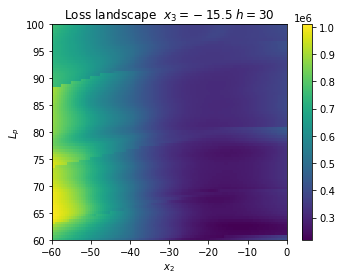

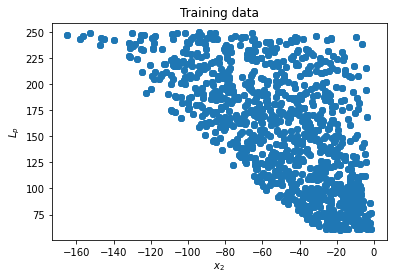

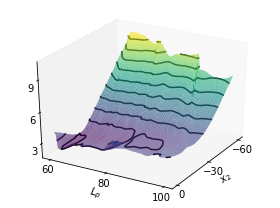

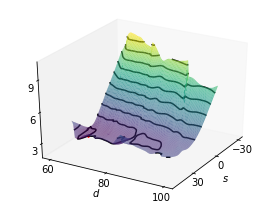

In [16]:
X, Y = np.meshgrid(x2_range ,Lp_range)
plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, loss.transpose())
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$x_2$")
plt.ylabel(r"$L_p$")
plt.title("Loss landscape "+r" $x_3=-15.5 ~ h=30$")
plt.tight_layout()
plt.savefig("landscape-x2-Lp.pdf")


plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[2,:])
plt.xlabel(r"$x_2$")
plt.ylabel(r"$L_p$")
plt.title("Training data")
# plt.ylim([-30, 0])



fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")

ax.scatter([-11.565677642822266], [62.2564697265625], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, lw =0)
ax.grid(False)

ax.view_init(30, 30)
ax.set_xticks([0, -30, -60])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$x_2$", labelpad=-5)
ax.set_yticks([60, 80, 100])
ax.tick_params(axis='y', which='major', pad=-4)
ax.set_ylabel(r"$L_p$", labelpad=-5)

ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()



x1 = L_p.item()/2.0
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
X += Y/2
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")

ax.scatter([-11.565677642822266 + x1], [62.2564697265625], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, lw =0)
ax.grid(False)

ax.view_init(30, 30)
ax.set_xticks([30, 0, -30])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$s$", labelpad=-5)
ax.set_yticks([60, 80, 100])
ax.tick_params(axis='y', which='major', pad=-4)
ax.set_ylabel(r"$d$", labelpad=-5)

ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()
fig.savefig("landscape-2.pdf")

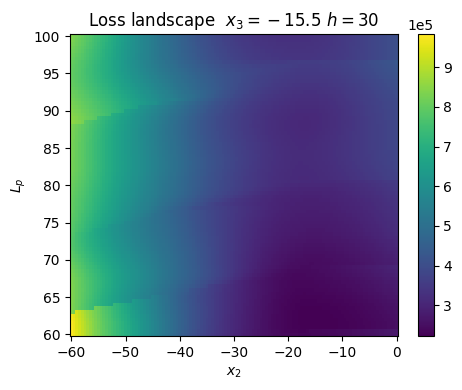

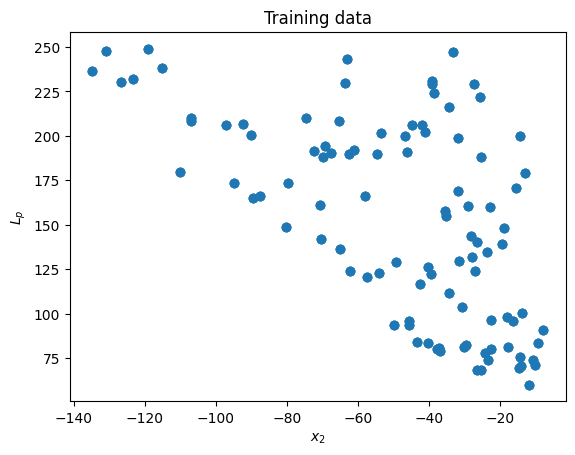

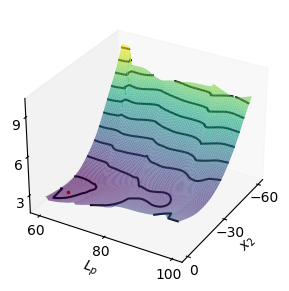

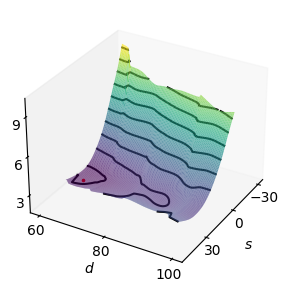

In [17]:
X, Y = np.meshgrid(x2_range ,Lp_range)
plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, loss.transpose())
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$x_2$")
plt.ylabel(r"$L_p$")
plt.title("Loss landscape "+r" $x_3=-15.5 ~ h=30$")
plt.tight_layout()
plt.savefig("landscape-x2-Lp.pdf")


plt.figure()
plt.scatter(inputPara_raw[4,:], inputPara_raw[2,:])
plt.xlabel(r"$x_2$")
plt.ylabel(r"$L_p$")
plt.title("Training data")
# plt.ylim([-30, 0])



fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")

ax.scatter([-11.565677642822266], [62.2564697265625], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, lw =0)
ax.grid(False)

ax.view_init(30, 30)
ax.set_xticks([0, -30, -60])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$x_2$", labelpad=-5)
ax.set_yticks([60, 80, 100])
ax.tick_params(axis='y', which='major', pad=-4)
ax.set_ylabel(r"$L_p$", labelpad=-5)

ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()



x1 = L_p.item()/2.0
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
X += Y/2
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")

ax.scatter([-11.565677642822266 + x1], [62.2564697265625], [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, lw =0)
ax.grid(False)

ax.view_init(30, 30)
ax.set_xticks([30, 0, -30])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$s$", labelpad=-5)
ax.set_yticks([60, 80, 100])
ax.tick_params(axis='y', which='major', pad=-4)
ax.set_ylabel(r"$d$", labelpad=-5)

ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()
fig.savefig("landscape-2.pdf")

In [18]:
# L_p, x2, x3, h
# fix L_p, h
# L_p, x1, x2, x3, h = 62.2564697265625,  -31.12823486328125, -11.565677642822266, 


x3, x2 = -15.864848136901855, -11.565677642822266
x3, x2 =  torch.tensor(x3, dtype=torch.float), torch.tensor(x2, dtype=torch.float)

Lp_range = np.linspace(60, 100, 40*4 + 1)
h_range = np.linspace(20, 30, 10*4 + 1)

xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
loss = np.zeros((len(Lp_range), len(h_range)))
for i in range(len(Lp_range)):
    for j in range(len(h_range)):
        Lp, h = torch.tensor(Lp_range[i], dtype=torch.float), torch.tensor(h_range[j], dtype=torch.float)
        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, Lp, x2, x3, h, N_s)

        out = torch.exp(model2(X_Y)).mean(-1).squeeze().detach().cpu().numpy()
        loss[i,j] = -np.dot(out, xx_mask)* L_x/N_s
        
            

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


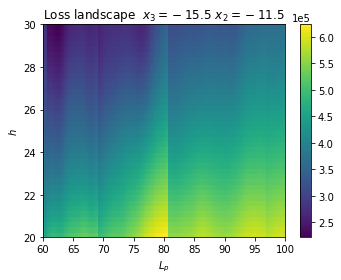

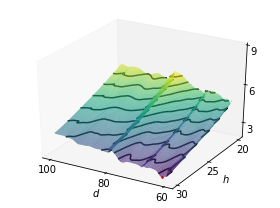

In [35]:
X, Y = np.meshgrid(Lp_range, h_range)
plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, loss.transpose())
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$L_p$")
plt.ylabel(r"$h$")
plt.title("Loss landscape "+r" $x_3=-15.5 ~ x_2=-11.5$")
plt.tight_layout()
plt.savefig("landscape-Lp-h.pdf")





x1 = L_p.item()/2.0
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")

ax.scatter([62.2564697265625], [30.0],  [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, lw =0)
ax.grid(False)

ax.view_init(30, 120)
ax.set_xticks([60, 80, 100])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$d$", labelpad=-5)
ax.set_yticks([20, 25, 30])
ax.tick_params(axis='y', which='major', pad=-4)
ax.set_ylabel(r"$h$", labelpad=-5)

ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()
fig.savefig("landscape-3.pdf")

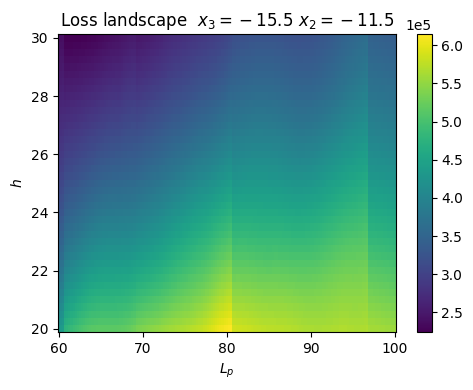

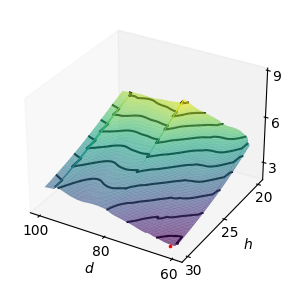

In [19]:
X, Y = np.meshgrid(Lp_range, h_range)
plt.figure(figsize=(5,4))
plt.pcolormesh(X, Y, loss.transpose())
cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))
plt.xlabel(r"$L_p$")
plt.ylabel(r"$h$")
plt.title("Loss landscape "+r" $x_3=-15.5 ~ x_2=-11.5$")
plt.tight_layout()
plt.savefig("landscape-Lp-h.pdf")





x1 = L_p.item()/2.0
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111, projection='3d')
ax.contour(X.T, Y.T, (loss), 10,  colors="black", linestyles="solid")

ax.scatter([62.2564697265625], [30.0],  [(217993.265625)],  s=10, marker='.', color='r', zorder=3)
ax.plot_surface(X.T, Y.T, (loss), rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', alpha=0.7, lw =0)
ax.grid(False)

ax.view_init(30, 120)
ax.set_xticks([60, 80, 100])
ax.tick_params(axis='x', which='major', pad=-4)
ax.set_xlabel(r"$d$", labelpad=-5)
ax.set_yticks([20, 25, 30])
ax.tick_params(axis='y', which='major', pad=-4)
ax.set_ylabel(r"$h$", labelpad=-5)

ax.set_zticks([3e5, 6e5, 9e5])
ax.tick_params(axis='z', which='major', pad=-4)

ax.ticklabel_format(axis='z', style='scientific',  scilimits=(1,4), useMathText=True)
fig.tight_layout()
fig.savefig("landscape-3.pdf")

sum =  2799.364882352539
dx2_x1 =  5  loss =  255175.6075719778
sum =  2289.896807639795
dx2_x1 =  10  loss =  227980.44721974965
sum =  2039.2285318814027
dx2_x1 =  15  loss =  213658.09801476402
sum =  1945.2794734523154
dx2_x1 =  20  loss =  214384.4063785294
sum =  2195.1462626454722
dx2_x1 =  25  loss =  234873.56951246053
sum =  2367.489784163824
dx2_x1 =  28  loss =  256646.07476506257
sum =  2528.150900401163
dx2_x1 =  30  loss =  268334.41000783106


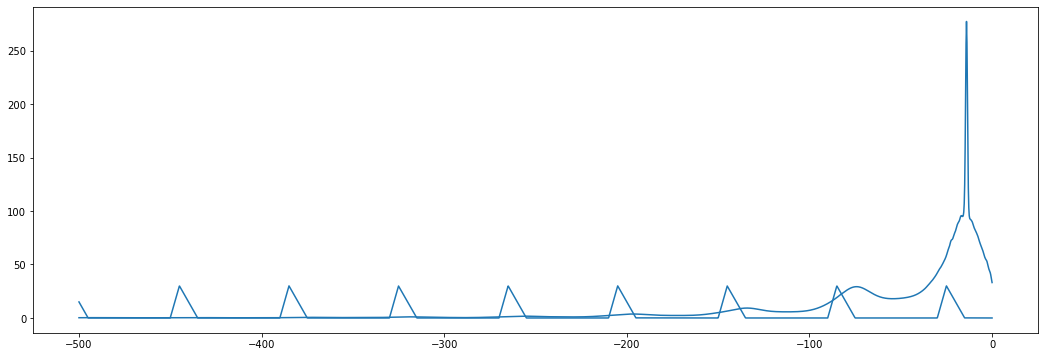

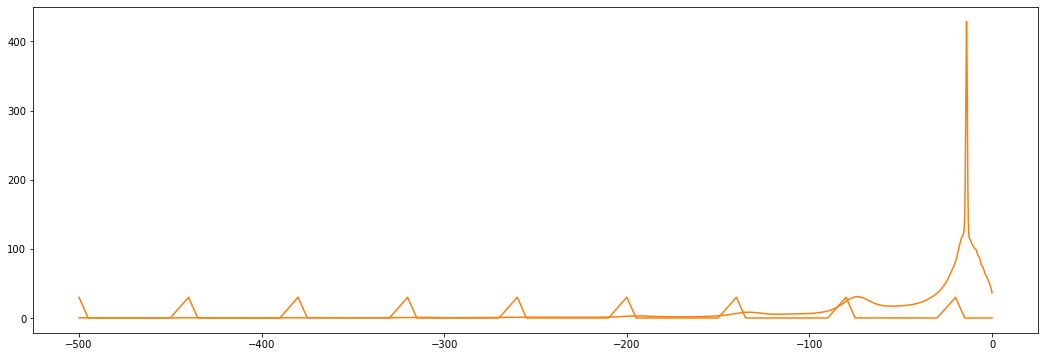

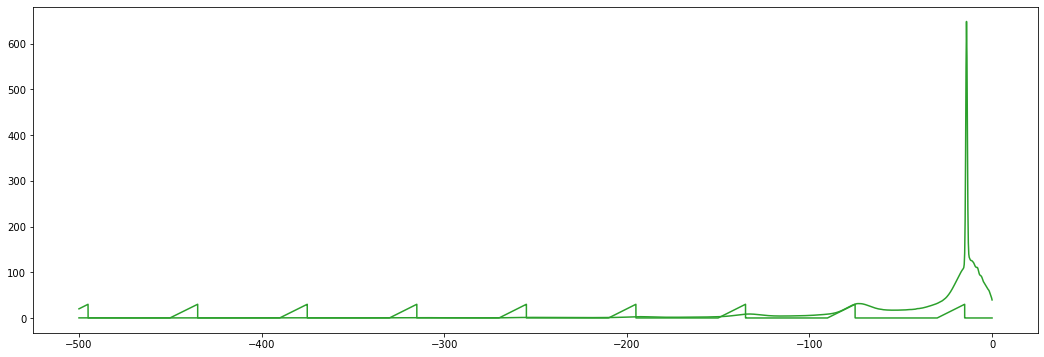

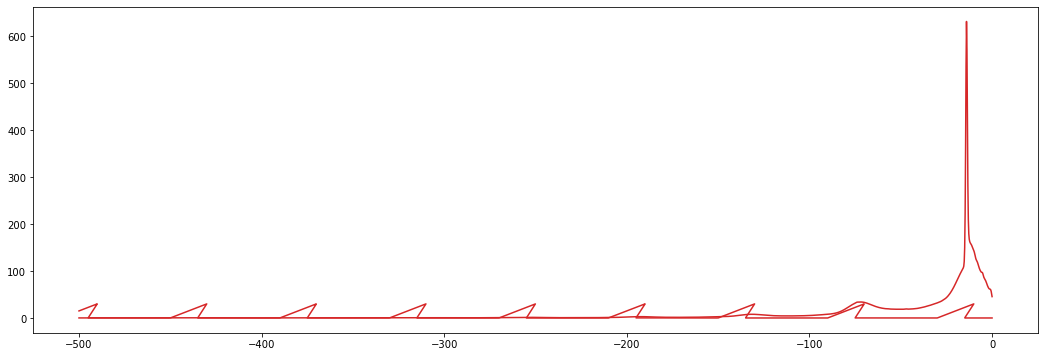

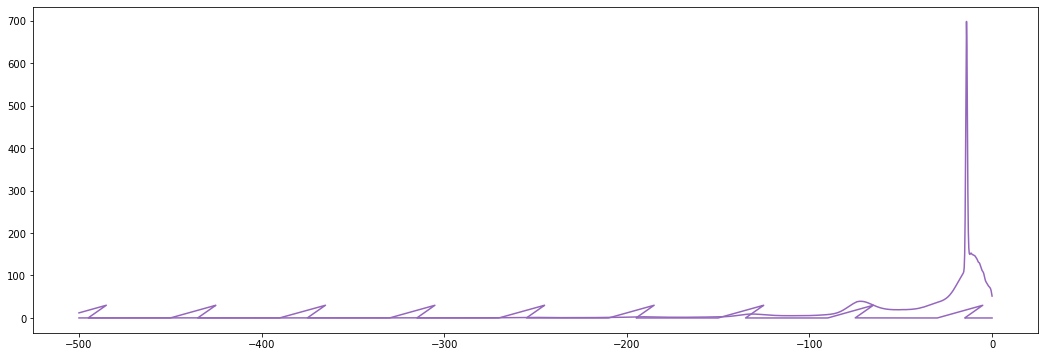

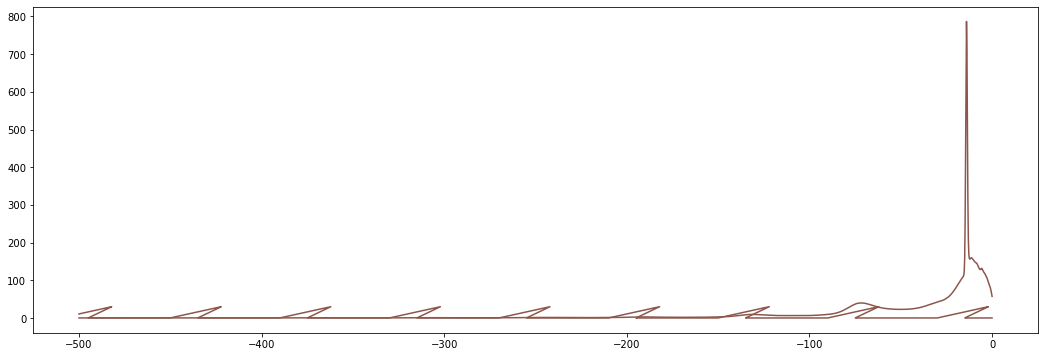

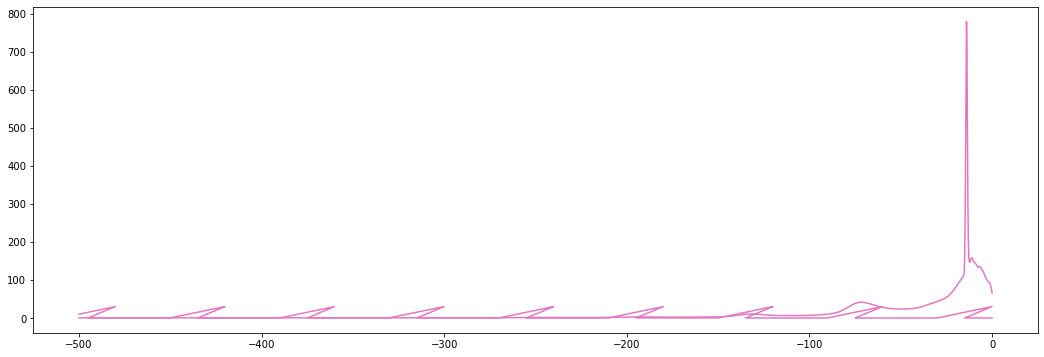

In [28]:
train_data_folder = "/home/tingtaoz/storage/traindatalevy/optimizedtests0906/"

# Study the effect of bw_method
t = 9


N_s, L_x = 2001, 500
L_p, x1, x3, h = 60.0, -30.0, -15, 30.0
bw_method = 1e-1
xx = np.linspace(-L_x, 0.0, N_s)
dx2_x1_list = np.array([5, 10, 15, 20, 25, 28, 30])
true_loss = np.zeros(len(dx2_x1_list))
x_mesh, y_mesh = np.zeros((len(dx2_x1_list), N_s)), np.zeros((len(dx2_x1_list), N_s))
density_1d_data_all = np.zeros((len(dx2_x1_list), N_s, 3))
density_1d_data = np.zeros((len(dx2_x1_list), N_s))
for i in range(len(dx2_x1_list)):
    dx2_x1 = dx2_x1_list[i]
    x_mesh[i,:], y_mesh[i,:] = numpy_catheter_mesh_1d_total_length(L_x, L_p, x1, x1+dx2_x1, x3, h, N_s)
    
    file_names = glob.glob(train_data_folder+"/x2_"+str(dx2_x1)+"_U020uf*")
    for file_name in file_names:
        
        uf  = np.float64(  file_name[file_name.find("uf") + len("uf"):  file_name.find("alpha")]  )
        # sample is from 1 - 1000
        j = 0
        if uf < (5.0 + 10.0)/2:
            j = 0
        elif uf < (10. + 15.0)/2:
            j = 1
        elif uf < (15. + 20.0)/2:
            j = 2
        else:
            print("error! uf = ", uf)
            
        
        # preprocee density
        hf = h5py.File(file_name, "r")
        x_b = hf["config"][str(t+1)]["x"][:]
        y_b = hf["config"][str(t+1)]["y"][:]

        if(min(x_b) < -L_x):
            print("warning: bacteria out of the domain. file_name = ", file_name, " loc = ", min(x_b), " end point = ", -L_x)

        

        bacteria_1d_data = x_b[np.logical_and(x_b <= 0 , x_b >= -L_x)]
        n_particle = len(bacteria_1d_data)
        kernel = stats.gaussian_kde(bacteria_1d_data, bw_method = bw_method)
        density_1d_data_all[i, :, j] = kernel(xx)*n_particle
    
    density_1d_data[i, :] = np.mean(density_1d_data_all[i, :, :], axis=1)
    print("sum = ", sum(density_1d_data[i, 0:1600]))
    true_loss[i] = -np.dot(density_1d_data[i, :], xx)* L_x/N_s
    
    print("dx2_x1 = ",dx2_x1, " loss = ", -np.dot(density_1d_data[i, :], xx)* L_x/N_s)
    
    plt.figure(figsize=(18,6))
    plt.plot(xx,  density_1d_data[i, :], color="C"+str(i))
    plt.plot(x_mesh[i, :], y_mesh[i, :], color="C"+str(i))


loss =  [919083.09323029 898040.00870055 876921.20585135 856371.89755078
 836591.64249283 816976.40483663 797205.39932488 777223.59597422
 757104.3999711  737427.78177979 718336.65113683 699187.79778248
 679859.91624077 660668.72859649 641430.293804   621906.03346156
 602485.29440293 583540.7932552  565128.5233287  547113.52549339
 528846.45469953 509645.53553624 489524.90245275 469734.39400405
 450614.64704331 432522.45788028 415931.88779631 400593.61155478
 386208.5493077  372850.3761742  359751.84305836 346343.43294769
 332920.96732127 319688.92507291 306698.45944507 294139.16897162
 282204.68974659 271374.82403281 262219.43867828 254054.87172448
 246658.40177789 240010.77588969 234503.46957479 230305.03824962
 227085.46522363 224579.30780922 222750.69639714 221612.69968268
 221120.05004962 221158.78443896 221633.08460404 222534.67279437
 223906.8648089  225634.28338427 227650.56765621 230061.32921572
 232696.67800029 235337.2398441  237725.80261361 240030.41426713
 242316.80220746]

/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


loss =  [883526.58043562 863555.92411863 843857.61603352 824233.7861224
 804967.58232198 785680.1435054  766159.46335628 746731.06065796
 727560.14929469 709166.3804282  691367.77687669 673905.16362105
 656689.23715064 639606.89513616 622379.59369785 605040.41824473
 587961.34441778 571541.86751348 555440.61948398 538899.20122832
 521344.44710328 502495.4549163  483201.16752736 464449.94715347
 446395.78583336 429224.09458868 413197.75436519 398335.40151748
 384722.2327274  371480.08080244 358108.04293091 344190.19221911
 330390.58742764 316911.17409881 303808.85301838 291284.13912045
 279691.94926014 269845.0590875  261427.91059405 253934.64675556
 247381.99182565 241802.90989946 237332.20500219 233954.55254619
 231439.46811866 229457.51578736 227995.60625998 227127.41675963
 226748.68213083 226890.51120936 227519.5966841  228581.68260055
 230035.34105057 231627.24963201 233413.30249231 235449.37032567
 237617.29717511 239857.48827379 241960.89777954 244025.91022033
 246013.68740953]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


loss =  [849222.10936465 830949.51887339 812881.10215141 794423.91586798
 775834.57253402 757243.03543647 738771.74851233 720538.12430431
 702775.33092669 685760.2335801  669409.5095685  653422.73669688
 637817.55449751 622170.1754876  606533.86036719 590757.2908139
 574725.72549489 559233.73648733 543963.52864445 527808.25112338
 510592.77117219 492607.37928744 474327.52432509 456566.43480619
 439485.41843117 423234.8985445  407995.45742191 393914.90491288
 380547.45652144 367341.10464686 353514.40705347 339421.57331349
 325470.83395297 311728.14840017 298466.06549672 285898.70394345
 275008.74969519 266113.76085901 258197.06757789 251375.09704455
 245730.44607821 241120.9786507  237598.95062072 234943.13812035
 232795.77126282 231142.44238729 229968.12172048 229336.45443117
 229132.86555054 229316.53755439 229943.69842162 231155.25983898
 232760.60333826 234548.57322158 236486.74021216 238608.40196331
 240874.59084977 243250.20899051 245630.68558465 248014.42901387
 250320.71193554]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


loss =  [818645.37298184 801800.76161186 784728.48365487 767101.11053671
 749504.32239458 732150.21483496 715047.98983186 698250.06908621
 681708.92469078 665412.17687527 649324.69326636 633614.98169337
 618335.56488764 603308.18157417 588149.54768547 572670.2234895
 557240.12078001 542747.96887343 528251.01705813 512987.03627026
 497003.79467813 480370.77068521 463535.87443137 446800.91408673
 430629.29317265 414981.72924605 399814.02767585 385486.14705923
 371475.4241293  357172.76545661 342718.24131766 328085.7906387
 313282.91259708 298678.58255758 284959.44899968 272905.24509977
 263450.09459029 255360.97128511 248395.52554914 242582.69171738
 238084.49151873 234974.47170011 232731.75526892 231993.88931551
 244658.32974987 251373.26179528 255361.75913491 260204.83036171
 265978.92330237 272862.50210518 280486.28206574 288614.87416089
 297233.2834111  306337.80565964 315867.50174971 325593.62892007
 335334.63538377 344877.71286529 354313.51685394 363633.08109277
 372924.70733077]


/home/dzhuang/miniconda3/envs/qg/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


loss =  [788095.77548745 770949.43812303 753702.93295138 736694.62476787
 719884.76738991 703208.50206474 686557.2405838  669801.51033023
 653488.98398147 637883.34308237 622595.72766767 607236.77096683
 591787.96388015 575947.48763068 559902.53992799 544322.6070377
 529921.5622445  515819.40106243 501111.7441767  485578.26623756
 469386.9529769  452793.49972211 435979.97011929 419215.0981853
 403080.09291651 387738.64792067 373091.24398333 358000.02529323
 341946.56817335 324866.89972419 308211.41792009 292623.12247223
 278549.03811954 266672.94613042 257601.7744463  250870.74435571
 246635.65713873 244050.12572076 241847.4378884  240473.81079656
 242872.2936183  246302.40266492 251335.50615613 257286.8741917
 263688.47511414 270870.25235891 278634.28946323 287057.02224298
 296184.85963642 305667.451845   315321.69962048 324793.86183922
 334005.41757509 343027.99821159 351953.35813258 360880.43841732
 369709.70218814 378409.4904804  387064.1731067  395956.34920091
 404693.60145654]


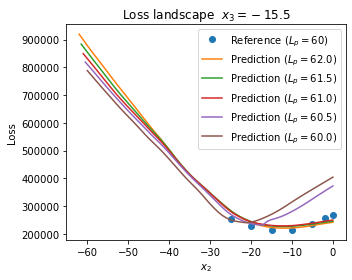

In [47]:
model = torch.load("catheter_plain_length_model_1d1000", map_location=device)

# This is for L_p = 60, x_3 = 15
fig, ax = plt.subplots(1, figsize=(5,4))
ax.plot(-L_p/2 + dx2_x1_list, true_loss,  "o", label="Reference "+ r"$(L_p=60)$")
x3 = -15.5
# L_p, x2, x3, h
# fix L_p, h
for L_p in [62, 61.5, 61, 60.5, 60]:
    h = 30.0
    L_p, h =  torch.tensor(L_p, dtype=torch.float), torch.tensor(h, dtype=torch.float)

    # 60.89578107 -30.44789053  -3.74659224 -15.23394195  28.72308896
    nx2 = 60+1
    x2_range = np.linspace(-L_p, 0.0, nx2)
    x3 = torch.tensor(x3, dtype=torch.float)
    xx_mask = numpy.linspace(1.0, 0, N_s) * (-L_x)
    loss = np.zeros(len(x2_range))
    for i in range(len(x2_range)):
        x2 = torch.tensor(x2_range[i], dtype=torch.float)

        X_Y, X, Y = catheter_mesh_1d_total_length(L_x, L_p, x2, x3, h, N_s)

        #out = model(X_Y).squeeze().detach().cpu().numpy()
        out = torch.exp(model(X_Y).squeeze()).detach().cpu().numpy()

        loss[i] = -np.dot(out, xx_mask)* L_x/N_s
        
    print("loss = ", loss)
    ax.plot(x2_range, loss, label="Prediction "+r"$(L_p=%3.1f)$" %L_p)

ax.set_xlabel(r"$x_2$")
ax.set_ylabel(r"Loss")
plt.title("Loss landscape "+r" $x_3=-15.5$")
plt.tight_layout()
ax.legend()
plt.savefig("Landscape_loss_Lp.pdf")
# ax.set_ylim([2e5,3e5])

/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf10.0906alpha1.5tauR2_13.2834_15.0299_28.3752.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf5.04531alpha1.5tauR2_13.2834_15.0299_28.3752.h5old.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf15.1359alpha1.5tauR2_13.2834_15.0299_28.3752.h5old.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf10.0906alpha1.5tauR2_13.2834_15.0299_28.3752.h5old.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf15.1359alpha1.5tauR2_13.2834_15.0299_28.3752.h5
/home/tingtaoz/storage/traindatalevy/allparams/0823/sample633_U020uf5.04531alpha1.5tauR2_13.2834_15.0299_28.3752.h5
dx2_x1 =  30  loss =  272731.6552793368


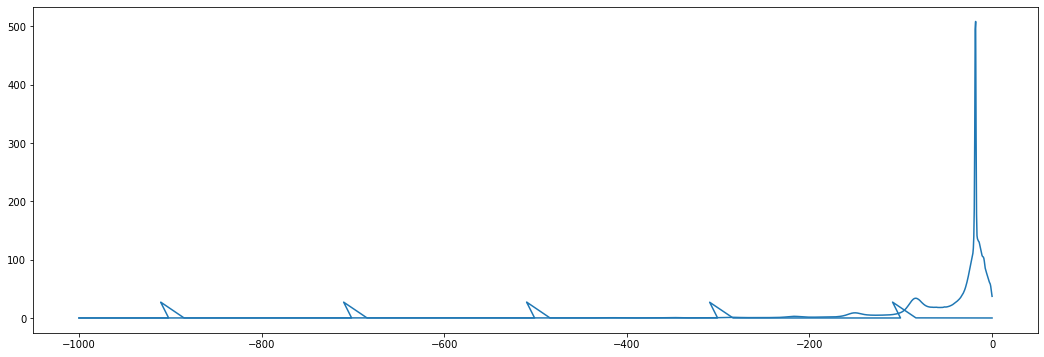

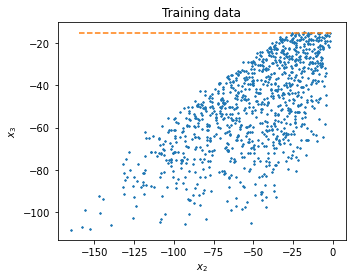

In [48]:
plt.figure(figsize=(5,4))
plt.scatter(inputPara_raw[4,:], inputPara_raw[5,:], s=1)
plt.plot([-160, 0], [-15.5, -15.5], "--", color="C1")
plt.xlabel(r"$x_2$")
plt.ylabel(r"$x_3$")
plt.title("Training data")
plt.tight_layout()
plt.savefig("Data_x2_x3.pdf")